# Movie Reviews Classificaiton and NLP

https://www.kaggle.com/competitions/word2vec-nlp-tutorial/data

Running a sentiment classificaiton task on Movie Reviews where the embedding will be compared between BERT and FastText. For Classification Random Forest and Logistic Regression will be used.

# 1.  Importing Packages 

In [153]:
import time
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.metrics import *
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import gensim as gs
from gensim.utils import simple_preprocess
from gensim.models import FastText
import torch
from transformers import BertModel,BertTokenizer
from sentence_transformers import SentenceTransformer

# 2. Importing Data # 

In [9]:
labeled_train_data = pd.read_csv('labeledTrainData.tsv', sep= '\t')

# 3. Initial Data Exploration

In [10]:
labeled_train_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [11]:
labeled_train_data.describe(include = 'all')

,id,sentiment,review
count,25000,25000.00000,25000
unique,25000,NaN,24904
top,5814_8,NaN,"When i got this movie free from my job, along ..."
freq,1,NaN,3
mean,NaN,0.50000,NaN
std,NaN,0.50001,NaN
min,NaN,0.00000,NaN
25%,NaN,0.00000,NaN
50%,NaN,0.50000,NaN
75%,NaN,1.00000,NaN


## 3.1 Duplicates

In [12]:
# Checking duplicates
labeled_train_data.duplicated().sum()

0

In [13]:
labeled_train_data.review

0        With all this stuff going down at the moment w...
1        \The Classic War of the Worlds\" by Timothy Hi...
2        The film starts with a manager (Nicholas Bell)...
3        It must be assumed that those who praised this...
4        Superbly trashy and wondrously unpretentious 8...
                               ...                        
24995    It seems like more consideration has gone into...
24996    I don't believe they made this film. Completel...
24997    Guy is a loser. Can't get girls, needs to buil...
24998    This 30 minute documentary Buñuel made in the ...
24999    I saw this movie as a child and it broke my he...
Name: review, Length: 25000, dtype: object

In [14]:
# Review example
labeled_train_data.review[0]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

##  3.2 Null values

In [15]:
# No null values
labeled_train_data.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

## 3.3 Sentiment Distribution

<AxesSubplot: ylabel='sentiment'>

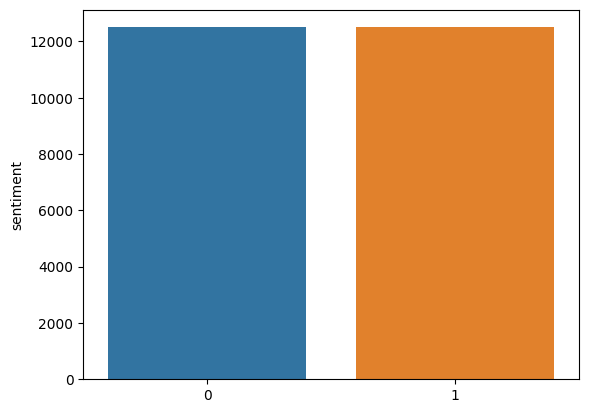

In [16]:
# Sentiment distribution
sentiment_dist = pd.DataFrame(labeled_train_data.sentiment.value_counts())
sns.barplot(data = sentiment_dist, x = sentiment_dist.index, y = 'sentiment')

## 3.3 Review Length Distribution

In [17]:
# Creating the variable legnth of review. 
review_length = labeled_train_data.review.apply(lambda x : len(x))
review_length = pd.DataFrame(review_length)
review_length.columns = ['review_text_length']
review_length['sentiment'] = labeled_train_data.sentiment

<AxesSubplot: xlabel='review_text_length', ylabel='Density'>

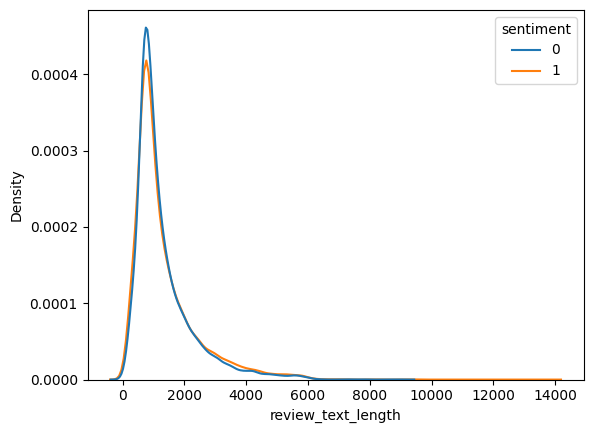

In [18]:
# Checking distributions between 
sns.kdeplot(data = review_length, x = 'review_text_length', hue="sentiment")

<AxesSubplot: xlabel='sentiment', ylabel='review_text_length'>

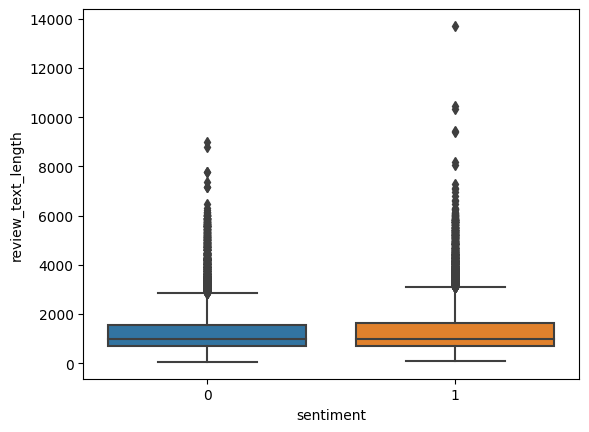

In [19]:
sns.boxplot(data = review_length, x = 'sentiment', y = 'review_text_length')

In [20]:
# Running Mann Whitney U and KS 2 Sample Test. 

In [21]:
stats.ks_2samp(review_length[review_length.sentiment == 0].review_text_length.values, review_length[review_length.sentiment == 1].review_text_length.values, alternative='two-sided')




KstestResult(statistic=0.027760000000000007, pvalue=0.00012852445841707123)

In [22]:
mannwhitneyu(review_length[review_length.sentiment == 0].review_text_length.values, review_length[review_length.sentiment == 1].review_text_length.values)





MannwhitneyuResult(statistic=78057021.5, pvalue=0.9051616533936246)

In [23]:
# Different P-values recieved from both tests. Need to investigate later why. Distributions though look the same.

In [24]:
review_length[review_length.sentiment == 0].review_text_length.describe()

count    12500.000000
mean      1305.721920
std        959.142634
min         52.000000
25%        711.000000
50%        978.000000
75%       1569.250000
max       8999.000000
Name: review_text_length, dtype: float64

In [25]:
review_length[review_length.sentiment == 1].review_text_length.describe()

count    12500.000000
mean      1349.699200
std       1048.890394
min         70.000000
25%        695.000000
50%        984.000000
75%       1653.000000
max      13708.000000
Name: review_text_length, dtype: float64

# 

In [26]:
labeled_train_data['tokenized_reviews'] = labeled_train_data.review.apply(lambda x : simple_preprocess(x))

In [27]:
labeled_train_data.tokenized_reviews

0        [with, all, this, stuff, going, down, at, the,...
1        [the, classic, war, of, the, worlds, by, timot...
2        [the, film, starts, with, manager, nicholas, b...
3        [it, must, be, assumed, that, those, who, prai...
4        [superbly, trashy, and, wondrously, unpretenti...
                               ...                        
24995    [it, seems, like, more, consideration, has, go...
24996    [don, believe, they, made, this, film, complet...
24997    [guy, is, loser, can, get, girls, needs, to, b...
24998    [this, minute, documentary, buñuel, made, in, ...
24999    [saw, this, movie, as, child, and, it, broke, ...
Name: tokenized_reviews, Length: 25000, dtype: object

# 4. Fast Text Embedding + Modelling

##  4.1 Text Data Preprocessing

In [28]:
# Tokenizing the sentences using Simple Preprocess
labeled_train_data['tokenized_reviews'] = labeled_train_data.review.apply(lambda x : simple_preprocess(x))

In [29]:
labeled_train_data.tokenized_reviews.head(5)

0    [with, all, this, stuff, going, down, at, the,...
1    [the, classic, war, of, the, worlds, by, timot...
2    [the, film, starts, with, manager, nicholas, b...
3    [it, must, be, assumed, that, those, who, prai...
4    [superbly, trashy, and, wondrously, unpretenti...
Name: tokenized_reviews, dtype: object

## 4.2 Fast Text Embedding

In [30]:
# Using FastText to avoid Data Leakage issues when it comes to word embeddings. 
fast_text_model = FastText(sentences = labeled_train_data.tokenized_reviews, min_count = 1)

## 4.3 Text Data Preprocessing Continuation

In [31]:
# Creating an list with the embeddings
total_word_list = list()
for x in range(0,len(labeled_train_data)):
    current_sentence = labeled_train_data.tokenized_reviews[x]
    sentence_list = list()
    for word in current_sentence:
        sentence_list.append(fast_text_model.wv[word])
    total_word_list.append(sentence_list)

In [32]:
total_mean_of_each_element = list()
for i in range(0,len(total_word_list)):
    sentence = total_word_list[i]
    mean_of_each_element = list()
    for dimension in range(0,100):
        n_element_array = sum(np.array(sentence)[:,dimension])
        mean_of_each_element.append(n_element_array)

    total_mean_of_each_element.append(mean_of_each_element)

In [33]:
embeddings_columns = pd.DataFrame(total_mean_of_each_element)

columns_names = list()
for i in range(0,100):
    columns_names.append(f"d_{i}")
    
embeddings_columns.columns = columns_names

In [34]:
training_dataset = pd.concat([labeled_train_data,embeddings_columns], axis = 1)
training_dataset = training_dataset.drop(columns = ['id','review','tokenized_reviews'])

In [35]:
training_dataset.head(5)

,sentiment,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99
0,1,-92.388723,375.172887,551.503384,-145.110292,217.548742,-41.384465,-69.980175,268.329465,193.231569,...,-20.867283,188.065382,-358.524873,-292.212985,40.618915,-118.974356,386.005227,-79.896153,300.758541,-143.932930
1,1,-19.615338,131.119128,190.710311,-63.937427,72.052164,-121.154734,-65.418691,141.358464,66.299512,...,-13.125705,49.010813,-67.399990,-11.720045,73.353879,-34.478229,101.424223,-73.557770,137.230420,-76.214195
2,0,-270.958384,327.900884,263.428188,-33.050763,309.577498,-47.471635,9.835426,492.825806,110.079031,...,-30.164117,205.574521,-210.541221,-5.898930,18.878710,155.123072,152.845901,-74.181861,179.087257,-65.678502
3,0,-111.554758,426.646803,223.986302,-67.398090,285.145288,-91.493708,-44.781914,415.844394,154.805422,...,-147.060159,182.388416,-115.013618,-92.278630,143.773340,-18.344638,191.818890,-78.291218,317.652147,-194.720029
4,1,-200.166025,414.882380,221.574560,63.951765,282.683304,-98.541747,13.083171,232.649180,95.824230,...,-98.140487,152.847466,-265.710699,-84.354150,72.837404,27.489824,177.562197,53.726376,224.208451,-140.083977


## 4.4 Model Data Preprocessing 

In [36]:
y_data = training_dataset.sentiment.values
x_data = training_dataset.drop(columns = 'sentiment')
x_train, x_validation, y_train, y_validation = train_test_split(x_data, y_data, random_state = 0)

## 4.5 Model Creation

In [55]:
# Initialize a Random Forest Model
random_forest_model = RandomForestClassifier(n_estimators = 500)

# Initialize a Logistic Regression

logistic_regression_model = LogisticRegression(max_iter=1000)

# Fitting the models with the training dataset
random_forest_model.fit(x_train,y_train)
print('RF Done')

logistic_regression_model.fit(x_train,y_train)
print('LR Done')

RF Done
LR Done


In [42]:
def return_predicted_score(model,threshold,x_data, y_data):
    predicted_prob = model.predict_proba(x_data)[:,1]
    predicted_df = pd.DataFrame()
    predicted_df['predicted'] = predicted_prob
    predicted_df['true_value'] = y_data
    predicted_df['predicted_integer'] =  np.where(predicted_prob > threshold,1,0)
    return predicted_df


In [57]:
# Random Forest Metrics
random_forest_predicted = return_predicted_score(random_forest_model,0.5, x_data, y_data)

# Checking the Accuracy of the model on the training dataset
f"Random Forest Training Dataset Accuracy : {random_forest_model.score(x_train,y_train)*100}%"

'Random Forest Training Dataset Accuracy : 100.0%'

In [61]:
# Logistic Regression Evaluation
logistic_regression_predicted = return_predicted_score(logistic_regression_model,0.5, x_data, y_data)

# Checking the Accuracy of the model on the training dataset
f"Logistic Regression Training Dataset Accuracy : {logistic_regression_model.score(x_train,y_train)*100}%"

'Logistic Regression Training Dataset Accuracy : 82.46933333333332%'

Accuracy is slightly lower for the logistic regression model

### 4.5.1 K-Fold Cross Validation

In [165]:
# Running 5 fold cross validation to check performance on unseen data for the RF model 
scores = cross_val_score(random_forest_model, x_data, y_data, cv=5)
scores_rf

In [50]:
scores

NameError: name 'scores' is not defined

In [63]:
# Running 5 fold cross validation to check performance on unseen data for the RF model 
scores_lr = cross_val_score(logistic_regression_model, x_data, y_data, cv=5)
scores_lr

array([0.8252, 0.8246, 0.8206, 0.8266, 0.8184])

### 4.5.2 Validation dataset

In [64]:
# Validation dataset
y_predicted_sentiment = random_forest_model.predict_proba(x_validation)[:,1]
predicted_df_valid_data_set = pd.DataFrame()
predicted_df_valid_data_set['predicted'] = y_predicted_sentiment
predicted_df_valid_data_set['true_value'] = y_validation
predicted_df_valid_data_set['predicted_integer'] =  np.where(y_predicted_sentiment > 0.5,1,0)
validation_score = random_forest_model.score(x_validation,y_validation)
print(f"Validation Accuracy : {validation_score}")

Validation Accuracy : 0.82512


In [65]:
pd.crosstab(predicted_df_valid_data_set.true_value, predicted_df_valid_data_set.predicted_integer)

predicted_integer,0,1
true_value,,
0,2408,747
1,809,2286


# 5. BERT Sentence Transformer  Embedding + Modelling


## 5.1 BERT - Sentence Transformer Embedding

In [67]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [78]:
labeled_data_bert = labeled_train_data.copy()
labeled_data_bert = labeled_data_bert.drop(columns = ['review','tokenized_reviews','id'])

In [79]:
sentences = labeled_train_data.review.tolist()
embeddings = model.encode(sentences)
embeddings_df = pd.DataFrame(embeddings)
final_embeddings_df = pd.concat([labeled_data_bert,embeddings_df], axis = 1)

column_names = list()
for i in range(1,385):
    column = f"dimension_{i}"
    column_names.append(column)

final_embeddings_df.columns = ['sentiment'] + column_names


1095.9721519947052


In [80]:
final_embeddings_df.head()

,sentiment,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,...,dimension_375,dimension_376,dimension_377,dimension_378,dimension_379,dimension_380,dimension_381,dimension_382,dimension_383,dimension_384
0,1,-0.039965,-0.039945,0.032377,-0.031316,0.048586,0.029957,0.025492,0.087440,0.017422,...,0.054313,0.030366,0.000056,0.110934,-0.052167,-0.070681,0.119820,-0.027335,0.015433,-0.092829
1,1,-0.053401,0.021124,0.024965,0.026388,-0.012323,0.088172,0.027656,0.000255,0.069894,...,0.056176,0.033124,-0.010126,0.037054,-0.079876,0.000295,0.044663,0.048541,0.051261,0.069462
2,0,-0.113776,-0.005263,-0.061372,0.065549,0.074117,-0.042920,0.044736,0.055372,0.055255,...,-0.043556,-0.012978,-0.039647,-0.063544,-0.018210,-0.024293,0.038012,-0.013207,0.003768,0.038215
3,0,-0.025800,0.024685,0.004377,-0.007853,-0.068596,0.063245,0.088030,0.056862,0.011959,...,0.000214,-0.024788,0.015227,0.127534,-0.049338,-0.001192,0.106704,0.033528,0.013115,-0.010662
4,1,-0.045250,0.018018,-0.049859,0.050957,0.060951,0.000819,0.087774,0.044912,0.003276,...,0.040007,-0.051709,-0.001937,0.048413,-0.011869,0.078185,0.050383,-0.097763,0.023168,-0.076539


In [81]:
x_data_bert = final_embeddings_df.drop(columns = 'sentiment')
y_data_bert = final_embeddings_df['sentiment']
x_train_bert, x_validation_bert, y_train_bert, y_validation_bert = train_test_split(x_data_bert,y_data_bert)

## 5.2 Model Creation

In [85]:
# Initialize a Random Forest Model
random_forest_model_bert = RandomForestClassifier(n_estimators = 500)

# Initialize a Logistic Regression

logistic_regression_model_bert = LogisticRegression(max_iter=1000)

# Fitting the models with the training dataset
random_forest_model_bert.fit(x_data_bert,y_data_bert)
print('RF Done')

logistic_regression_model_bert.fit(x_data_bert,y_data_bert)
print('LR Done')

RF Done
LR Done


In [88]:
random_forest_model_bert.score(x_data_bert,y_data_bert)

1.0

Similar to above, perfect accuracy, meaning overfitting most likely.

In [89]:
logistic_regression_model_bert.score(x_data_bert,y_data_bert)

0.81952

### 5.2.1 K-Fold Cross Validation

#### 5.2.1.1 K-Fold Random Forest

In [ ]:
# Running 5 fold cross validation to check performance on unseen data. 
scores = cross_val_score(random_forest_bert, x_data_bert, y_data_bert, cv=5)
scores

In [319]:
f"Mean Accuracy Score {scores.mean()}, Standard Deviation {scores.std()}"

'Mean Accuracy Score 0.77904, Standard Deviation 0.0034857423886454843'

#### 5.2.1.2 K-Fold Logistic Regression

In [90]:
# Running 5 fold cross validation to check performance on unseen data. 
scores = cross_val_score(logistic_regression_model_bert, x_data_bert, y_data_bert, cv=10)
scores

6.724521160125732


array([0.8104, 0.8136, 0.82  , 0.8112, 0.8096, 0.8204, 0.8152, 0.8212,
       0.804 , 0.8096])

## 5.3 Hyperparameter Tuning

In [104]:
max_iter = range(1000, 4000)
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
C = np.arange(0, 1, 0.01)
random_grid ={
    'max_iter' : max_iter,
    'warm_start' : warm_start,
    'solver' : solver,
    'C' : C,
}

logistic_regression_bert_hyperparameter = RandomizedSearchCV(estimator = logistic_regression_model_bert, param_distributions = random_grid, n_iter = 10 ,cv = 10, random_state=0)
logistic_regression_bert_hyperparameter = logistic_regression_bert_hyperparameter.fit(x_data_bert,y_data_bert)

In [105]:
logistic_regression_bert_hyperparameter.best_params_

{'warm_start': False, 'solver': 'lbfgs', 'max_iter': 1526, 'C': 0.92}

In [106]:
logistic_regression_bert_final = LogisticRegression(warm_start = 'False', solver = 'lbfgs', max_iter = 1565, C = 0.8)
logistic_regression_bert_final.fit(x_data_bert,y_data_bert)

LogisticRegression(C=0.8, max_iter=1565, warm_start='False')

## 5.4 Cut-off Evaluation - Validation Dataset

In [149]:
# Training the final model on validation data to see what the optimal cut-off may be

#logistic_regression_bert_validation= LogisticRegression(warm_start = 'False', solver = 'lbfgs', max_iter = 1565, C = 0.8)
#logistic_regression_bert_validation.fit(x_train_bert,y_train_bert)

predicted_prob = logistic_regression_bert_validation.predict_proba(x_validation_bert)[:,1]
predicted_df = pd.DataFrame()
predicted_df['predicted'] = predicted_prob
predicted_df['true_value'] = y_validation_bert.values

In [166]:
accuracy_score_arr = list()
range_list = list(range(0,100,1))
for i in range_list:
    predicted_int = np.where(predicted_df['predicted'] > i/100, 1, 0 )
    acc_score = accuracy_score(y_validation_bert.values,predicted_int)
    accuracy_score_arr.append(acc_score)

In [168]:
max(list(zip(accuracy_score_arr,range_list)))

(0.81776, 52)

In [185]:
arr_range_array = np.array(list(zip(accuracy_score_arr,range_list)))

(Text(0.5, 0, 'Threshold'),
 Text(0, 0.5, 'Model Score'),
 <matplotlib.legend.Legend at 0x34d272fb0>)

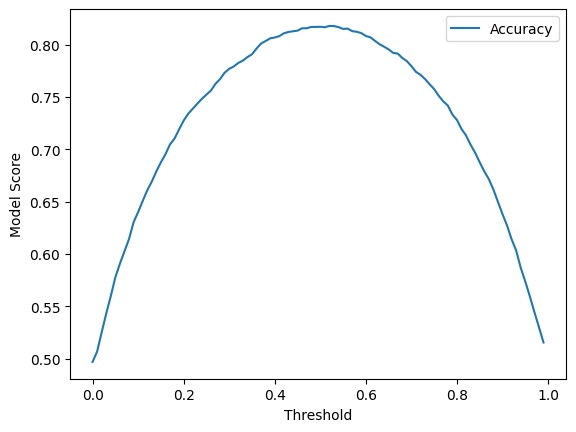

In [207]:
# Plotting Accuracy as a function of threshold 
sns.lineplot(data = arr_range_array, x = arr_range_array[:,1]/100, y = arr_range_array[:,0])
plt.xlabel("Threshold"),plt.ylabel("Model Score"),plt.legend(labels = ['Accuracy'])

# 6. Test Dataset

In [97]:
test_dataset = pd.read_csv('testData.tsv', sep = '\t')

## 6.1 Text Test Data Preprocessing

In [98]:
review_array = test_dataset.review.tolist()

In [99]:
encoded_arrays = model.encode(review_array)

In [100]:
dataframe_test_embeddings = pd.DataFrame(encoded_arrays)
dataframe_test_embeddings.columns  = column_names

In [101]:
dataframe_test_embeddings.head(5)

,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,dimension_10,...,dimension_375,dimension_376,dimension_377,dimension_378,dimension_379,dimension_380,dimension_381,dimension_382,dimension_383,dimension_384
0,0.005808,0.024933,0.030988,0.019990,0.024613,0.105117,0.000940,-0.000569,-0.005825,-0.066817,...,-0.002409,0.019028,-0.002423,0.089243,-0.029544,-0.000265,0.135016,0.011358,0.056377,0.030624
1,-0.001042,-0.063958,0.092036,-0.018966,0.027719,0.040837,-0.054760,-0.011183,0.031616,-0.086453,...,0.106740,-0.011178,0.042133,0.117130,-0.052834,0.014546,0.061212,-0.004508,-0.039833,-0.043648
2,-0.006448,-0.016426,0.096581,-0.000816,-0.015979,0.029404,0.032011,0.028757,0.020528,-0.041157,...,0.029266,-0.011709,-0.084302,0.026825,-0.081865,0.065426,0.061882,0.019927,-0.004408,0.057977
3,0.037065,-0.032434,0.002162,0.060671,0.054149,0.022480,-0.033056,0.075966,0.055994,-0.064029,...,0.039510,-0.059955,-0.039501,0.077020,-0.058440,-0.006432,0.043397,-0.040409,0.016318,0.012824
4,-0.011824,0.022300,-0.027188,-0.008771,0.089650,0.052296,-0.010083,0.023833,-0.010005,-0.056967,...,0.053532,0.004976,0.033880,0.097340,-0.025004,-0.011300,-0.019780,0.057387,-0.014426,-0.027723


In [169]:
predicted_test_sentiment = logistic_regression_bert_final.predict_proba(dataframe_test_embeddings)[:,1]
predicted_test_sentiment_int = np.where(predicted_test_sentiment > 0.52, 1, 0)

In [170]:
predicted_test_sentiment = pd.DataFrame()
predicted_test_sentiment['id'] = test_dataset.id
predicted_test_sentiment['sentiment'] = predicted_test_sentiment_int 
predicted_test_sentiment.to_csv('predicted_df.csv', index = False)